# Decision Tree

#### Imports

In [192]:
import numpy as np
import pandas as pd
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn import metrics 
import matplotlib.pyplot as plt
import seaborn as sns; sns.set(color_codes=True)

#### Decision Tree classes and functions

In [63]:
def entropy(data):
    unique , counts = np.unique(data, return_counts = True)
    px = counts / len(data)
    return -np.sum(px * np.log2(px))

In [158]:
class Node:

    def __init__(self, feature=None, threshold=None, left_node=None, right_node=None, *, output_class=None):
        self.feature = feature
        self.threshold = threshold
        self.left_node = left_node
        self.right_node = right_node
        self.output_class = output_class

    def is_leaf(self): # checks is node is a leaf
        return self.output_class != None
    
#   def print_node(self):
#       print("feature:", self.feature)
#       if self.left_node != None:
#           self.print_node()
#       if self.right_node != None:
#           self.print_node()
#       if self.output_class != None:
#           print("class: ", self.output_class)

In [251]:
class DecisionTree:

    def __init__(self, minsplit=2, max_depth=100):
        self.minsplit = minsplit
        self.max_depth = max_depth
        self.n_feats = None
        self.root = None

    def fit(self, X, y):
        self.n_feats = X.shape[1]# if not self.n_feats else min(self.n_feats, X.shape[1])
        self.root = self.grow_tree(X, y)

    def predict(self, X):
        #predict by traversing the tree until a leaf node is reached
        return np.array([self.traverse_tree(x, self.root) for x in X])

    def grow_tree(self, X, y, depth=0):
        n_samples, n_features = X.shape
        n_labels = len(np.unique(y))

        #recursion stopping criteria
        if (depth >= self.max_depth
                or n_labels == 1
                or n_samples < self.minsplit):
            leaf_value = self.most_common_class(y)
            return Node(output_class=leaf_value) # leaf created

        feat_inxs = np.random.choice(n_features, self.n_feats, replace=False)

        # select the best split according to information gain
        best_feat, best_thresh = self.best_criteria(X, y, feat_inxs)
        
        # grow the children that result from the split
        left_inxs, right_inxs = self.split(X[:, best_feat], best_thresh)
        left = self.grow_tree(X[left_inxs, :], y[left_inxs], depth+1) # recursion
        right = self.grow_tree(X[right_inxs, :], y[right_inxs], depth+1) # recursion
        return Node(best_feat, best_thresh, left, right) # new node created

    def best_criteria(self, X, y, feat_inxs):
        best_gain = -1
        split_inx, split_thresh = None, None
        for feat_inx in feat_inxs:
            X_column = X[:, feat_inx]
            thresholds = np.unique(X_column)
            for threshold in thresholds:
                gain = self.info_gain(y, X_column, threshold) # calc info_gain

                if gain > best_gain: # check if new gain if better than current gain
                    best_gain = gain
                    split_inx = feat_inx
                    split_thresh = threshold

        return split_inx, split_thresh

    def info_gain(self, y, X_column, split_thresh):
        # calc parent entropy
        parent_entropy = entropy(y)

        # generate split
        left_inxs, right_inxs = self.split(X_column, split_thresh)

        if len(left_inxs) == 0 or len(right_inxs) == 0:
            return 0

        # compute the weighted avg. of the loss for the children
        num = len(y)
        num_l, num_r = len(left_inxs), len(right_inxs)
        entropy_l, entropy_r = entropy(y[left_inxs]), entropy(y[right_inxs]) # calc entropy of each child
        child_entropy = (num_l / num) * entropy_l + (num_r / num) * entropy_r 

        gain = parent_entropy - child_entropy
        return gain

    def split(self, X_column, split_thresh):
        # following Binary Search Tree the left node contains values less than or equal to the threshold of the feature 
        # and the right node contains values greater than the threshold of the feature
        left_inxs = np.argwhere(X_column <= split_thresh).flatten() # flatten to create a vector
        right_inxs = np.argwhere(X_column > split_thresh).flatten()
        return left_inxs, right_inxs

    def traverse_tree(self, x, node):        
        #recursion stopping criteria
        if node.is_leaf():
            return node.output_class

        if x[node.feature] <= node.threshold: # if value for this feature is less than threshold for this feature move left
            return self.traverse_tree(x, node.left_node)
        return self.traverse_tree(x, node.right_node) # else move right

    def most_common_class(self, y):
        cls , count = np.unique(y, return_counts = True)
        mx = np.argmax(count)
        return cls[mx]


#### Apply to dataset

In [255]:
dataset = pd.read_csv("../Dataset/raw-banknote-data.csv",sep = ";") # read in data
dataset.head()

X = dataset.drop(columns = ["class"]) # input array
y = dataset.drop(columns = ["variance of image","skewness of image", "curtosis of image" , "entropy of image"]) # target array

X_train_v, X_test, y_train_v, y_test = train_test_split(X, y, test_size=0.2) # split test data
X_train, X_validation, y_train, y_validation = train_test_split(X_train_v, y_train_v, test_size=0.25) # split taining and validation data


In [253]:
tree = DecisionTree(max_depth=3) 
tree.fit(X_train.to_numpy(), y_train.to_numpy()) # fit data to tree
    
y_val = tree.predict(X_validation.to_numpy()) # predict class given validation array
print("Validation Accuracy:",metrics.accuracy_score(y_validation, y_val)) # calc accuracy of validation prediction

Validation Accuracy: 0.9527272727272728


Accuracy: 0.9454545454545454


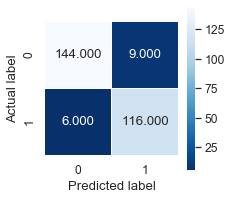

In [247]:
y_pred = tree.predict(X_test.to_numpy()) # using same tree predict test class

print("Accuracy:",metrics.accuracy_score(y_test, y_pred)) # calc accuracy of test prediction

cm = metrics.confusion_matrix(y_test, y_pred) # create confusion matrix

#display confusion matrix
sns.set(font_scale=1.1)
plt.figure(figsize=(3,3))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');

#print(metrics.classification_report(y_test, y_pred))